In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets import DatasetFolder
import torchvision
from torchvision.models import vgg16
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import copy
import os
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
# hyperparameter
batch_size = 1
lr = 0.00005
pca_dim = 2
n_epoch = 10
n_cluster = 8

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
# device = "cuda" if train_on_gpu else "cpu"
device = 'cpu'

CUDA is available!


In [21]:
train_path = '/home/chisc/workspace/wuzhenrong/train'
train_trans = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(100, 100)),
                                  transforms.Resize((252, 252)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.Resize((255, 255)),
                                  transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
                                  transforms.ToTensor()])
cat_data = ImageFolder(train_path, transform=train_trans)
cat_loader = DataLoader(cat_data, pin_memory=True, batch_size=batch_size, shuffle=True)

In [5]:
# images, labels = next(iter(train_loader))
# print(labels)
# for i in np.arange(3):
#     print(labels[i])
#     plt.figure(i)
#     plt.title('EFIGI')
#     plt.imshow(images[i].permute(1, 2, 0))
#     plt.show()
    
# un_images, un_labels = next(iter(unsuper_loader))
# print(un_labels)
# for i in np.arange(3):
#     print(un_labels[i])
#     plt.figure(i)
#     plt.title('GZ2')
#     plt.imshow(un_images[i].permute(1, 2, 0))
#     plt.show()

In [6]:
class DeepAutoEncoder(nn.Module):
    def __init__(self):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, bias=False), # 1->4
            nn.BatchNorm2d(6),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=3, stride=2, bias=False), # 1->4
            nn.BatchNorm2d(6),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3, stride=2, bias=False), # 4 -> 10
            nn.BatchNorm2d(3),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=2, stride=1, bias=False), # 10 -> 22
            nn.BatchNorm2d(3),
            # nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
#         print(x.shape)
        return x

In [7]:
# AE = DeepAutoEncoder().to(device)
# for i, (datas, labels) in enumerate(train_loader):
#     datas = datas.to(device)
#     x = AE(datas)
#     print(x.shape)
#     break

In [8]:
model = DeepAutoEncoder().to(device)
# model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = nn.L1Loss()

In [9]:
min_loss = 1000.
for epoch in range(n_epoch):
    for x, y in tqdm(cat_loader):
#         print(x.shape)
        x, y = x.to(device), y.to(device)
#         inputs = x.view(3, 256 * 256)
#         inputs = inputs.to(device)
        outputs = model(x)
#         print(outputs.shape)
        optimizer.zero_grad()
        loss = loss_func(outputs, x)
        loss.backward()
        optimizer.step()
        if loss < min_loss:
            min_loss = loss
            torch.save(model,"cat_test.pkl")
    print(f"epoch:{epoch+1}/{n_epoch}, Loss = {loss.item()}")
# torch.save(model, "test.pkl")

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:1/10, Loss = 0.5243472456932068


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:2/10, Loss = 0.46336671710014343


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:3/10, Loss = 0.4604191184043884


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:4/10, Loss = 0.4308914542198181


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:5/10, Loss = 0.4158201813697815


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:6/10, Loss = 0.3905785381793976


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:7/10, Loss = 0.38464802503585815


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:8/10, Loss = 0.39979177713394165


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:9/10, Loss = 0.36162370443344116


  0%|          | 0/125 [00:00<?, ?it/s]

epoch:10/10, Loss = 0.37988290190696716


In [22]:
model = torch.load("cat_test.pkl")
for i, (datas, labels) in tqdm(enumerate(cat_loader)):
    batch_size = 1
    datas = datas.to(device)
    x = model.encoder(datas)
    x = x.cpu().detach().numpy().reshape(batch_size, -1)
    if i == 0:
        featureList = x 
        labelsList = labels
    else:
#         print("hello")
        featureList = np.append(featureList, x, axis=0)
        labelsList = np.append(labelsList, labels, axis=0)
    # if i == 3:
    #     break
print(featureList.shape, labelsList.shape)


0it [00:00, ?it/s]

(4000, 5400) (4000,)


In [23]:
x_encode = TSNE(n_components=2).fit_transform(featureList)
print(x_encode.shape)

(4000, 2)


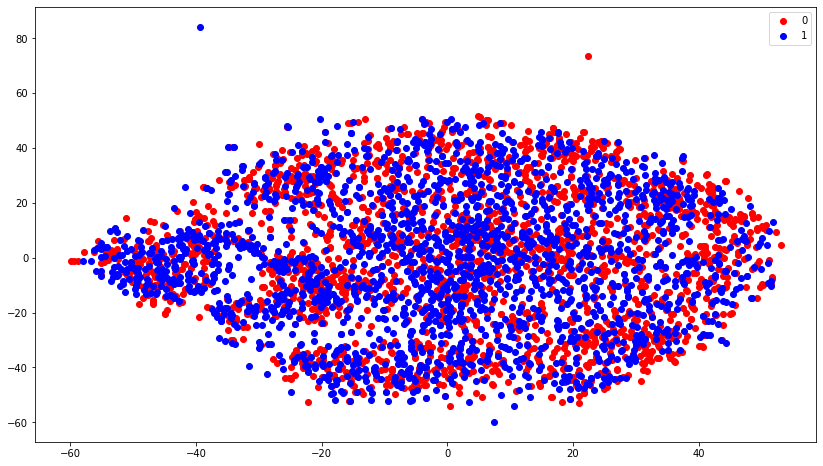

In [25]:
# cmap = plt.get_cmap('plasma',8)
color = ['red', 'blue', 'black', 'orange', 'green', 'pink', 'purple', 'gray', 'brown', 'lightblue']
v_x = x_encode
v_y = labelsList

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
classes = [0, 1]
for key in classes:
    ix = np.where(v_y==key)
    ax.scatter(v_x[ix][:,0], v_x[ix][:,1], color=color[key], label=key)
ax.legend()
plt.show()